In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [3]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                } ,
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                }  ,
                6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                } 
              ,

                
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                }
                
              
            
               
                }
test = {   5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }  }
appliances = ["Refrigerator"]

In [5]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.Tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
#     y_test = scaler_y.transform(y_test)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.Tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.Tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)

    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y, scaler_time


In [6]:
# import pandas as pd
# import jax.numpy as jnp
# from datetime import datetime
# from sklearn.preprocessing import StandardScaler
# import torch

# def dataset_load(appliances, train, test=None):
#     x_train = []
#     y_train = []
#     x_train_timestamp = []
#     scaler_x = StandardScaler()
#     scaler_y = StandardScaler()
#     scaler_time = StandardScaler()
#     # train
#     for key, values in train.items():
#         df = pd.read_csv(
#             f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
#         df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
#         startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
#         endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

#         if startDate > endDate:
#             raise "Start Date must be smaller than Enddate."

#         df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
#         df.dropna(inplace=True)
#         x = df["main"].values
#         y = df[appliances[0]].values
        
#         timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

#         x_train.extend(torch.tensor(x))
#         y_train.extend(torch.tensor(y))
#         x_train_timestamp.extend(torch.tensor(timestamp_train))

#     x_train = torch.tensor(x_train).reshape(-1, 1)
#     y_train = torch.tensor(y_train).reshape(-1, 1)
#     x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
#     x_train = scaler_x.fit_transform(x_train)
#     y_train = scaler_y.fit_transform(y_train)
#     x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)


#     # test
#     x_test = []
#     y_test = []
#     x_test_timestamp = []
#     for key, values in test.items():
#         df = pd.read_csv(
#             f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
#         df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
#         startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
#         endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

#         if startDate > endDate:
#             raise "Start Date must be smaller than Enddate."

#         df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
#         df.dropna(inplace=True)
#         x = df["main"].values
#         y = df[appliances[0]].values
#         timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

#         x_test.extend(torch.tensor(x))
#         y_test.extend(torch.tensor(y))
#         x_test_timestamp.extend(timestamp)

#     x_test = torch.tensor(x_test).reshape(-1, 1)
#     y_test = torch.tensor(y_test).reshape(-1, 1)
#     x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

#     x_test = scaler_x.transform(x_test)
#     x_test_timestamp = scaler_time.transform(x_test_timestamp)

#     x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1).contiguous()
#     y_train = torch.tensor(y_train).reshape(-1,).contiguous()
#     x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1).contiguous()
#     x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1).contiguous()
#     y_test = torch.tensor(y_test).reshape(-1,).contiguous()
#     x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).contiguous()


#     return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y


In [7]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, scaler_x, scaler_y,scaler_time = dataset_load(appliances, train, test)

In [8]:
x_train.shape

(67134, 99)

In [9]:
indexes = 53456
n = 99
# x_train_full = jnp.concatenate((jnp.array(x_train.reshape(-1,n)), jnp.array(np.array(x_train_timstamp))), axis=1)
# x_test_full = jnp.concatenate((jnp.array(x_test.reshape(-1,n)), jnp.array(np.array(x_test_timestamp))), axis=1)
# x_train_full.shape, x_test_full.shape

x = torch.Tensor(np.array(x_train))
y = torch.Tensor(np.array(y_train)).reshape(-1)
xt = torch.Tensor(np.array(x_test))
yt = torch.Tensor(np.array(y_test)).reshape(-1)

if x.shape[0]>indexes:
  x = x[:indexes]
  y = y[:indexes]

# xt1= x[indexes:]
# yt1 = y[indexes:]

In [10]:
x.shape, y.shape

(torch.Size([53456, 99]), torch.Size([53456]))

In [11]:
# x1.shape, y1.shape, x.size(-1), xt1.shape
#
# x = torch.Tensor(x[:20000,:])
# y = torch.Tensor(y[:20000])

In [12]:
# data_dim = x.size(-1)
# class LargeFeatureExtractor1(torch.nn.Sequential):
#     def __init__(self):
#         super(LargeFeatureExtractor1, self).__init__()
#         self.add_module('lstm', torch.nn.LSTM(data_dim, 256,4))
#         # self.add_module('linear1', torch.nn.Linear(data_dim, 250))
#         # self.add_module('relu1', torch.nn.ReLU())
#         # self.add_module('linear2', torch.nn.Linear(250, 50))     
#         # self.add_module('relu2', torch.nn.ReLU())                  
#         # self.add_module('linear3', torch.nn.Linear(50, 9))       
#         # self.add_module('relu3', torch.nn.ReLU())   
#         # self.add_module('linear4', torch.nn.Linear(250, 100))       
#         # self.add_module('relu4', torch.nn.ReLU())                         
#         # self.add_module('linear5', torch.nn.Linear(100, 9))

# class LargeFeatureExtractor2(torch.nn.Sequential):
#     def __init__(self):
#         super(LargeFeatureExtractor2, self).__init__()
#         # self.add_module('lstm', torch.nn.LSTM(data_dim, 500,2))
#         # self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
#         # self.add_module('relu1', torch.nn.ReLU())
#         # self.add_module('linear2', torch.nn.Linear(1000, 500))     
#         # self.add_module('relu2', torch.nn.ReLU())                  
#         self.add_module('linear1', torch.nn.Linear(256, 64))       
#         self.add_module('relu1', torch.nn.ReLU())   
#         self.add_module('linear2', torch.nn.Linear(64, 9))                          
#         # self.add_module('linear1', torch.nn.Linear(200, 99))  

# feature_extractor1 = LargeFeatureExtractor1().cuda()
# feature_extractor2 = LargeFeatureExtractor2().cuda()

In [13]:
class LSTM(torch.nn.Module):
    def __init__(self, hidden_layers=[256,256,256,256]):
        super(LSTM, self).__init__()
        self.hidden_layers1 = hidden_layers[0]
        self.hidden_layers2 = hidden_layers[1]
        self.hidden_layers3 = hidden_layers[2]
        self.hidden_layers4 = hidden_layers[3]
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = torch.nn.LSTMCell(x.shape[1], self.hidden_layers1)
        self.lstm2 = torch.nn.LSTMCell(self.hidden_layers1, self.hidden_layers2)
        self.lstm3 = torch.nn.LSTMCell(self.hidden_layers2, self.hidden_layers3)
        self.lstm4 = torch.nn.LSTMCell(self.hidden_layers3, self.hidden_layers4)
        self.lstm5 = torch.nn.LSTMCell(self.hidden_layers4, self.hidden_layers4)
        # self.lstm6 = torch.nn.LSTMCell(self.hidden_layers4, self.hidden_layers4)
        # self.lstm7 = torch.nn.LSTMCell(self.hidden_layers4, self.hidden_layers4)
        self.linear = torch.nn.Linear(self.hidden_layers4, x.shape[1])
        
    def forward(self,x1):
        h_t = torch.zeros(x1.shape[0], self.hidden_layers1).cuda()
        c_t = torch.zeros(x1.shape[0], self.hidden_layers1).cuda()
        h_t2 = torch.zeros(x1.shape[0], self.hidden_layers2).cuda()
        c_t2 = torch.zeros(x1.shape[0], self.hidden_layers2).cuda()
        h_t3 = torch.zeros(x1.shape[0], self.hidden_layers3).cuda()
        c_t3 = torch.zeros(x1.shape[0], self.hidden_layers3).cuda()
        h_t4 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        c_t4 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        h_t5 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        c_t5 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        # h_t6 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        # c_t6 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        # h_t7 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
        # c_t7 = torch.zeros(x1.shape[0], self.hidden_layers4).cuda()
    
        h_t, c_t = self.lstm1(x1, (h_t, c_t)) # initial hidden and cell states
        h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
        h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3)) # new hidden and cell states
        h_t4, c_t4 = self.lstm4(h_t3, (h_t4, c_t4)) # new hidden and cell states
        h_t5, c_t5 = self.lstm5(h_t4, (h_t5, c_t5)) # new hidden and cell states
        # h_t6, c_t6 = self.lstm6(h_t5, (h_t6, c_t6)) # new hidden and cell states
        # h_t7, c_t7 = self.lstm7(h_t6, (h_t7, c_t7)) # new hidden and cell states
        # print(0)
        output = self.linear(h_t5)

        return output
        
feature_extractor1 =LSTM().cuda()

In [14]:
# x1[np.arange(0,x1.shape[0], 10)].shape

In [15]:
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.base_covar_module = ( gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=n)) )
            #+ gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=1, active_dims=(49)))*gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(ard_num_dims=1, active_dims=(49)))
            # self.covar_module = gpytorch.kernels.GridInterpolationKernel(
            #     gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
            #     num_dims=2, grid_size=100
            # )
            self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[np.arange(0, train_x.shape[0], 95)], likelihood=likelihood)
            # print(self.covar_module)
            self.feature_extractor1 = feature_extractor1
            # self.feature_extractor2 = feature_extractor2

            # This module will scale the NN features so that they're nice values
            # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x1):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor1(x1)
            # print(projected_x.shape)
            # print(projected_x.shape, hn.shape,cn.shape)
            # projected_x = self.feature_extractor2(projected_x)
            # print(projected_x.shape, hn.shape,cn.shape)
            # projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"
            # project_x = projected_x
            # plt.figure()
            # plt.plot(projected_x.detach().cpu()[:,49],x1.detach().cpu()[:,49])
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
            # print(projected_x.dtype)
            mean_x = self.mean_module(projected_x) #projected_
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
# from gpytorch.means import ConstantMean
# from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel, PeriodicKernel
# from gpytorch.distributions import MultivariateNormal

# class GPRegressionModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, likelihood):
#         super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = ConstantMean()
#         self.base_covar_module = ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(0))) + ScaleKernel(RBFKernel(ard_num_dims=1, active_dims=(1)))*ScaleKernel(PeriodicKernel(ard_num_dims=1, active_dims=(1)))
#         self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[np.arange(0, train_x.shape[0], 30)], likelihood=likelihood)
#         self.feature_extractor = feature_extractor
#     def forward(self, x):

#         # We're first putting our data through a deep net (feature extractor)
#         # We're also scaling the features so that they're nice values
#         projected_x = self.feature_extractor(x)
#         projected_x = projected_x - projected_x.min(0)[0]
#         projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
#         mean_x = self.mean_module(projected_x)
#         covar_x = self.covar_module(projected_x)
#         return MultivariateNormal(mean_x, covar_x)

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(x, y, likelihood)

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

In [18]:
import tqdm
training_iterations = 1500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
loss_arr =[]
def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output= model(x.cuda())
        # print(output.loc.shape)
        # Calc loss and backprop derivatives
        loss = -mll(output, y.cuda())
        # loss_arr.append(loss.cpu())
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()
 
%time train()

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/desai.aadesh/miniconda3/envs/nlim/lib/python3.10/site-packages/gpytorch/kernels/inducing_point_kernel.py:61: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352645774/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  inv_root = torch.triangular_solve(eye, chol)[0]


CPU times: user 3h 17min 29s, sys: 30min 54s, total: 3h 48min 24s
Wall time: 6min 38s


In [19]:
# model_name = "Refri_induce25_trial2_lstm_build6.pt"
# torch.save(model.state_dict(), os.path.join(
#    "./deepkernel_models/", model_name))

In [20]:
# model_name =  "Refri_induce30_train_test_trial.pt"
# model.load_state_dict(torch.load(
#     os.path.join("./deepkernel_models/", model_name)))

In [21]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds= model(xt.cuda())

In [22]:
# print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_y.inverse_transform(preds.mean.cpu().reshape(-1,1)).squeeze()) - torch.tensor(scaler_y.inverse_transform(yt1.reshape(-1,1)).squeeze())))))
# yt1_trans = torch.tensor(scaler_y.inverse_transform(yt1.reshape(-1,1)).squeeze())

In [23]:
y_mean = np.array(preds.mean.cpu())
y_mean = scaler_y.inverse_transform(y_mean.reshape(-1,1)).squeeze()
y_mean2 = np.clip(y_mean,0,y_mean.max(),out=y_mean)

In [24]:
print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(y_mean2) - yt))))

Test MAE: 43.10635757446289


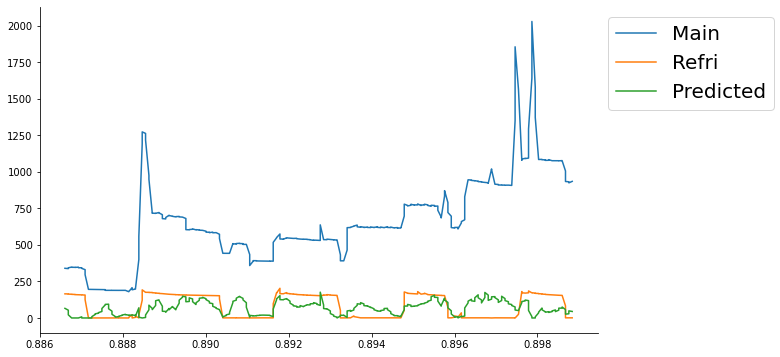

In [25]:
idx = 300
plt.figure(figsize=(10,6))
plt.plot(x_test_timestamp[:idx], scaler_x.inverse_transform(xt[:,:99].cpu())[:idx,49], label = "Main")
plt.plot(x_test_timestamp[:idx],yt[:idx], label = "Refri")
plt.plot(x_test_timestamp[:idx], y_mean2[:idx], label = "Predicted")
plt.legend(bbox_to_anchor=(1, 1),fontsize=20)
sns.despine()
# plt.savefig("./Results/Refrigerator_building5.png", bbox_inches="tight")

In [26]:
# model.eval()
# likelihood.eval()
# with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
#     preds = model(x.cuda())

In [27]:
# print('Test MAE: {}'.format(torch.mean(torch.abs(torch.tensor(scaler_y.inverse_transform(preds.mean.cpu().reshape(-1,1)).squeeze()) - scaler_y.inverse_transform(y.cpu().reshape(-1,1)))))

In [28]:
#Test MAE: 39.76863965146571 Building2
#Test MAE: 36.98316004753912 Building6
#Test MAE: 30.979215164980495 Building3
#Test MAE: 41.61947102463735 Building1
#Test MAE: 52.847451669822426 Building5

In [29]:
# 27.2431 6
# 35.66199 2
# 43.1256 5
# 39.92468 3
# 36.41136 1

# 36.47

36.87